In [1]:
import os
import pandas as pd
from utils.evaluation_utils import get_temporal_analysis_results, calculate_percentage_improvement
from pathlib import Path
import matplotlib.pyplot as plt
if "notebooks" in os.getcwd():
    os.chdir("..")
import matplotlib as mpl
import numpy as np

In [2]:
# Remove comment out for latex style font rendering (you need it installed on your system)
# mpl.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Latin Modern Roman"],
#     "axes.labelsize": 14,
#     "font.size": 16,
#     "legend.fontsize": 10,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "text.latex.preamble": r"\usepackage{amsmath}",
#     "legend.title_fontsize": 10
# })

In [41]:
temporal_results_path = Path("data/results/temporal_analysis.csv")
# if not temporal_results_path.exists():
if True:
    temporal_results = get_temporal_analysis_results(
        {
            1: [i for i in range(320, 375)]
            + [i for i in range(268, 316)],
            4: [i for i in range(201, 298)],
            8: [i for i in range(152, 249)] + [249, 250, 251]
        }
    )
    temporal_results.to_csv(temporal_results_path, index=False)

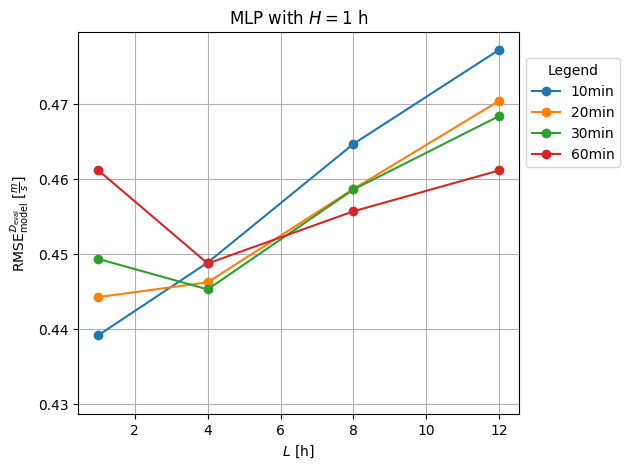

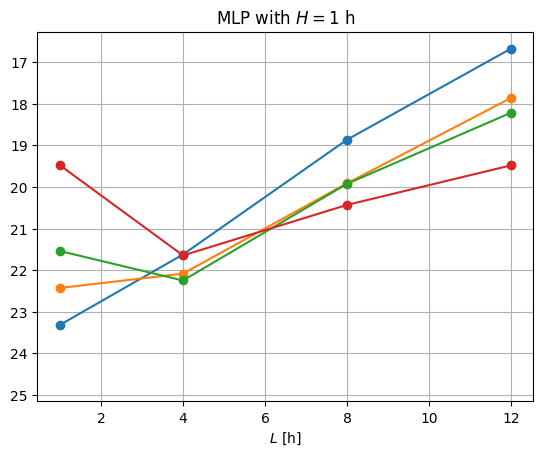

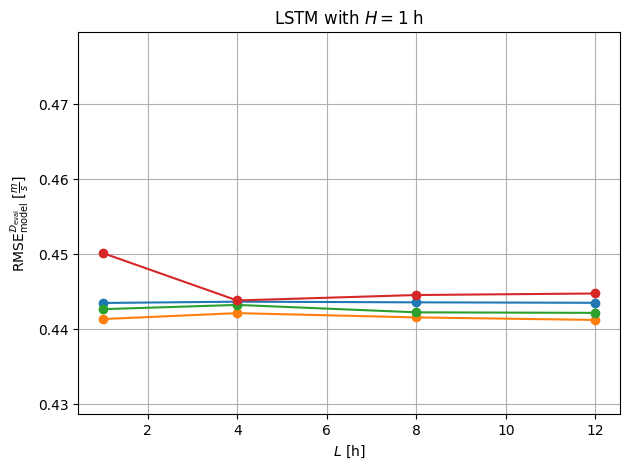

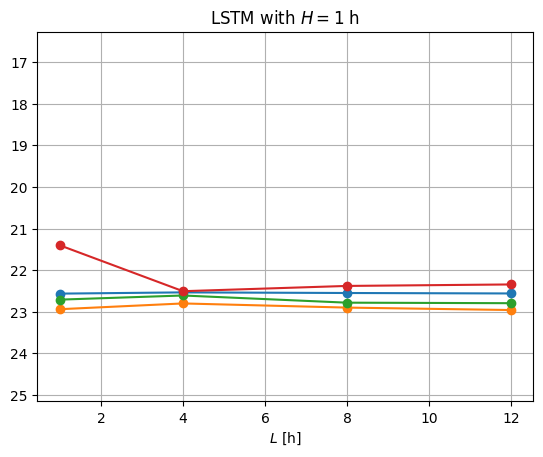

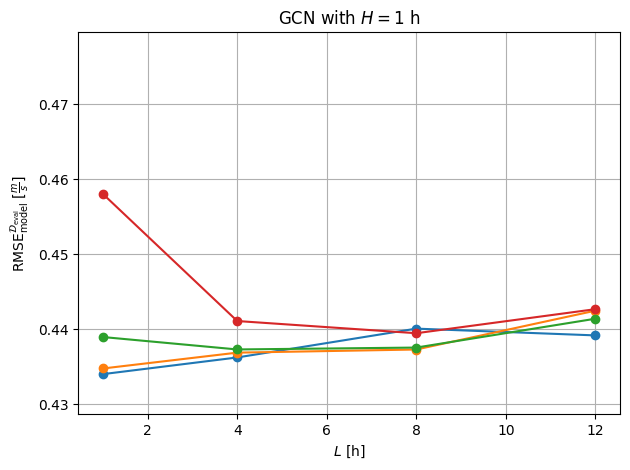

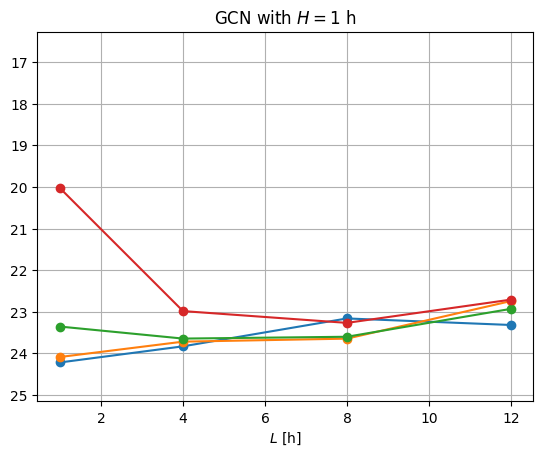

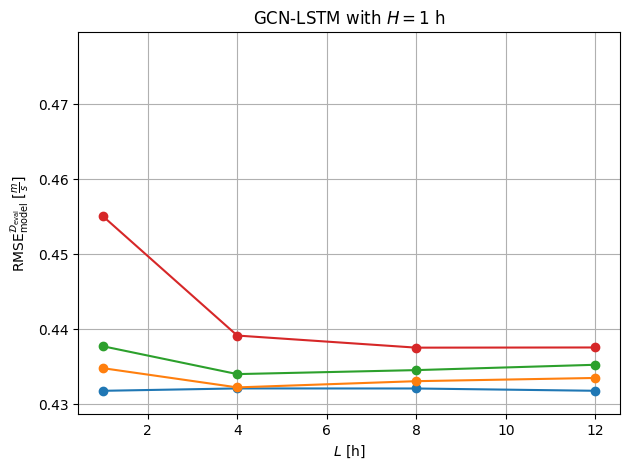

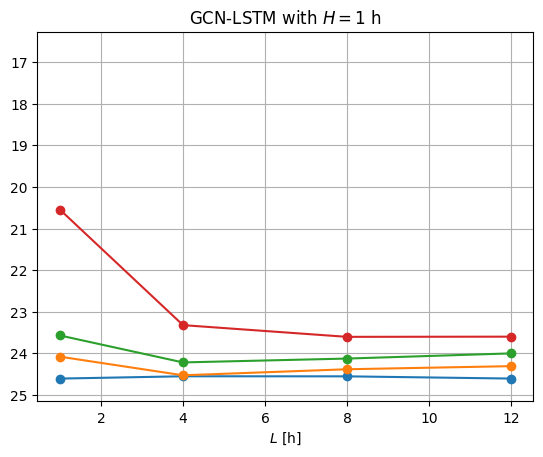

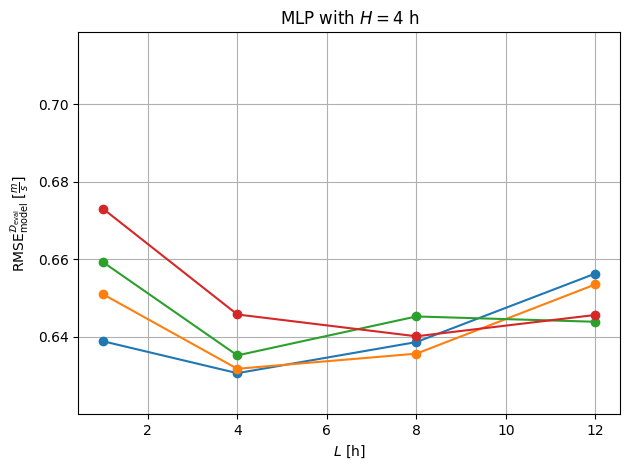

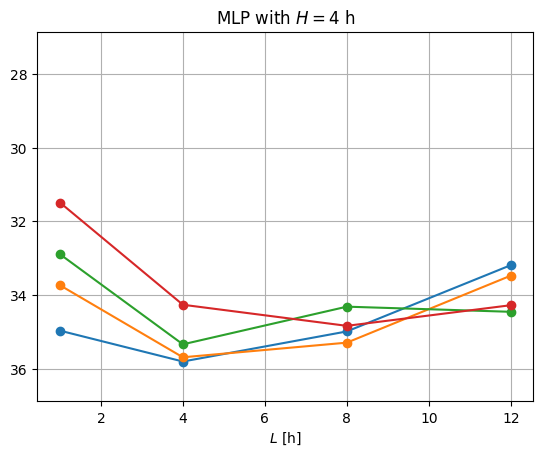

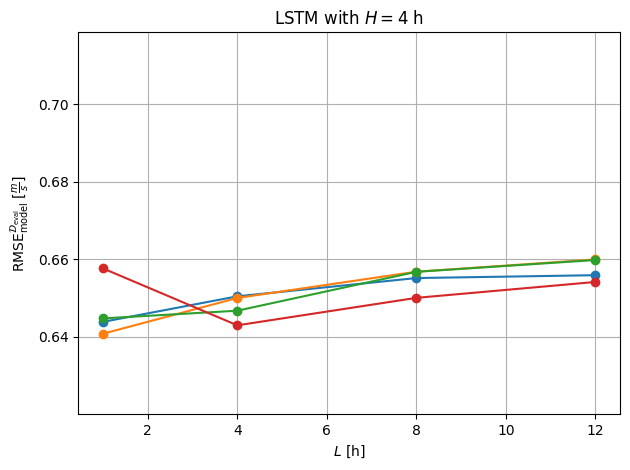

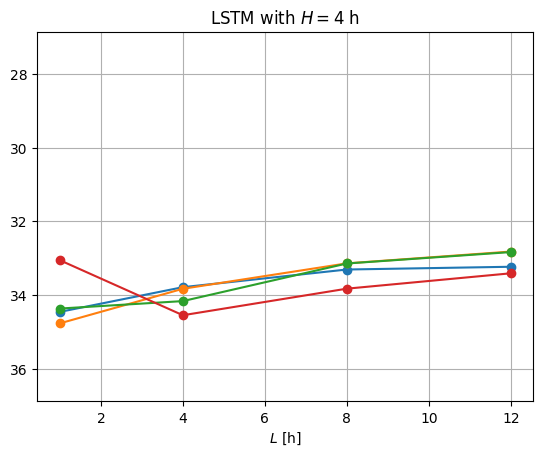

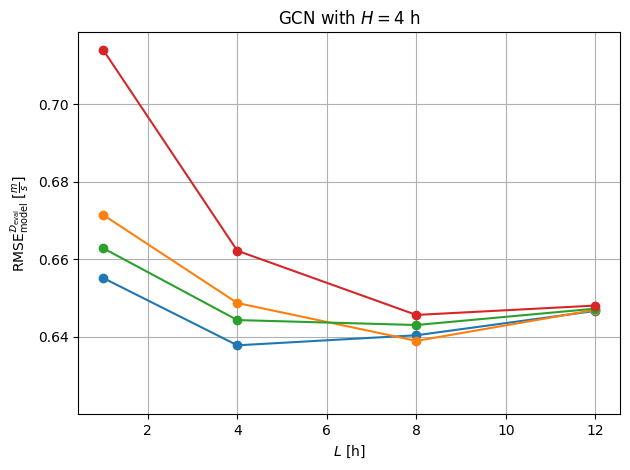

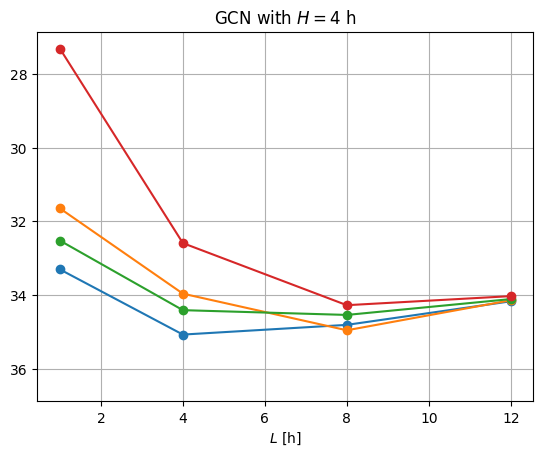

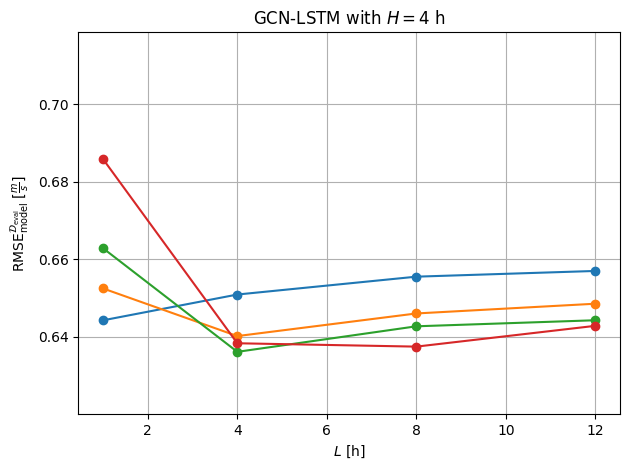

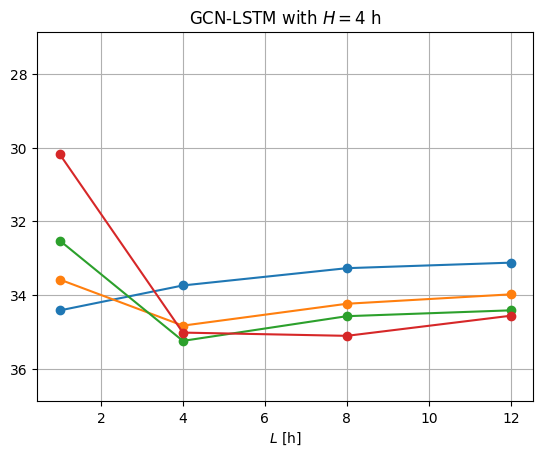

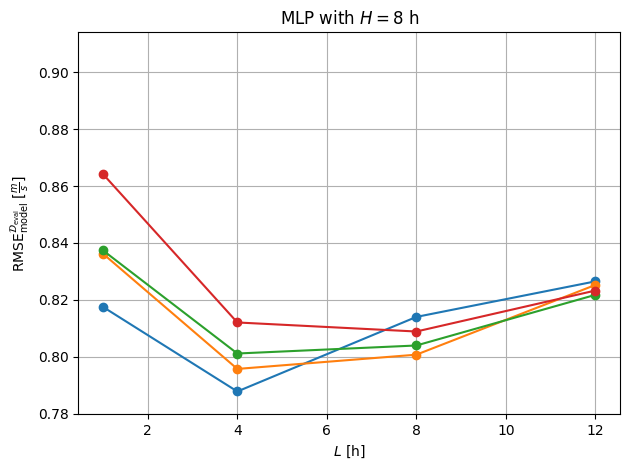

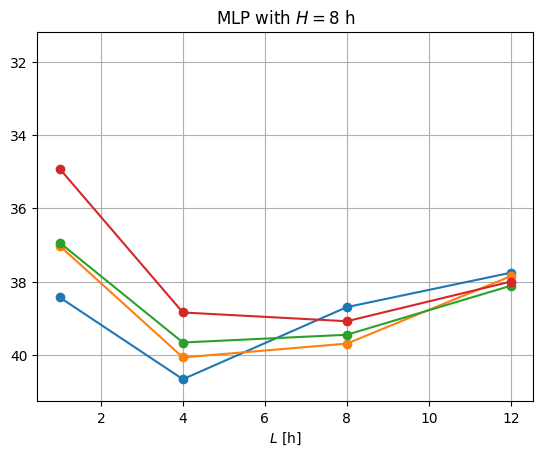

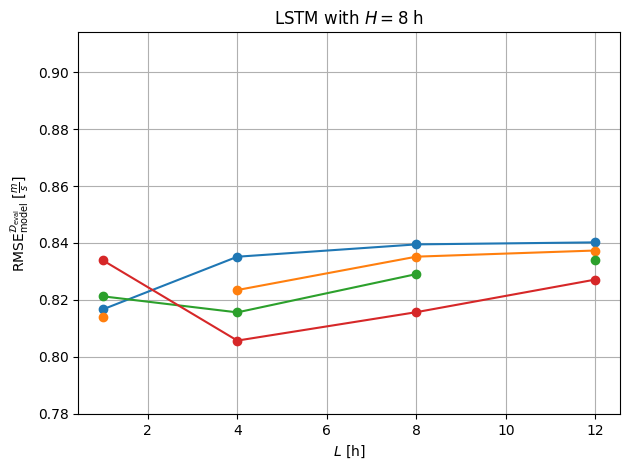

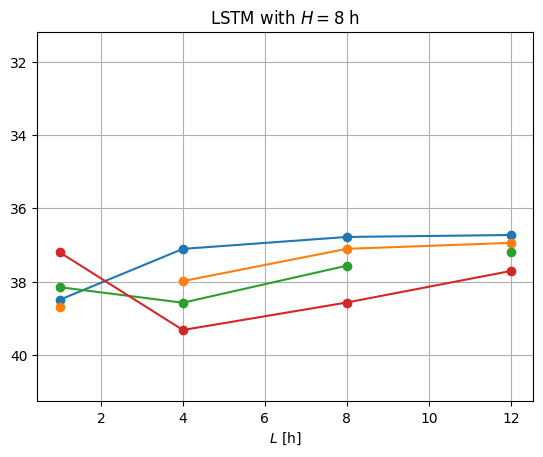

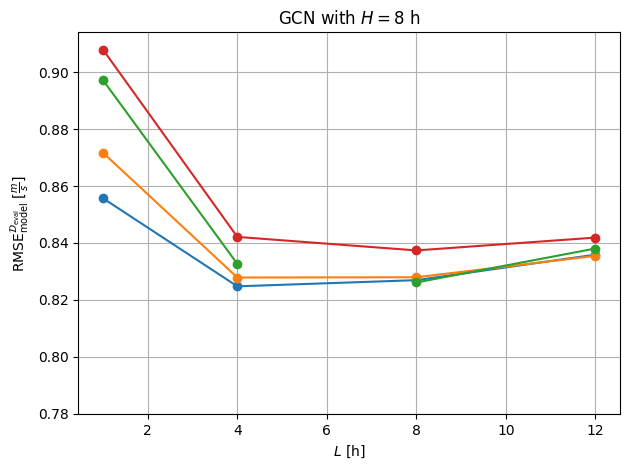

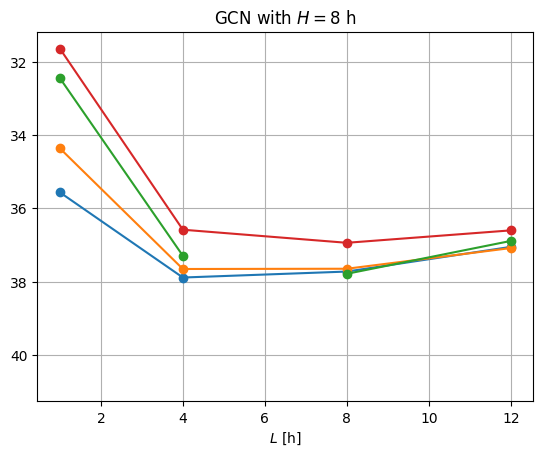

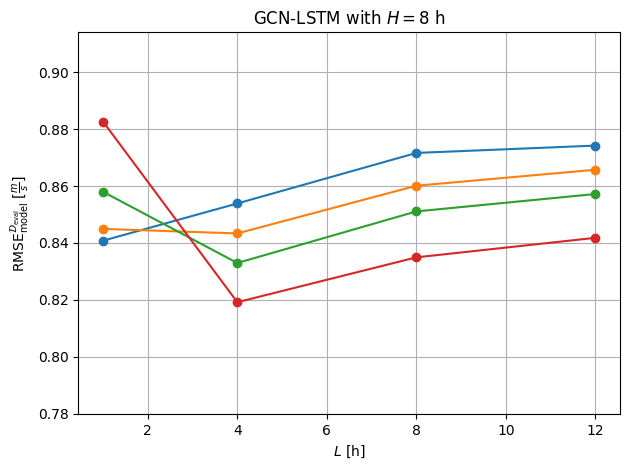

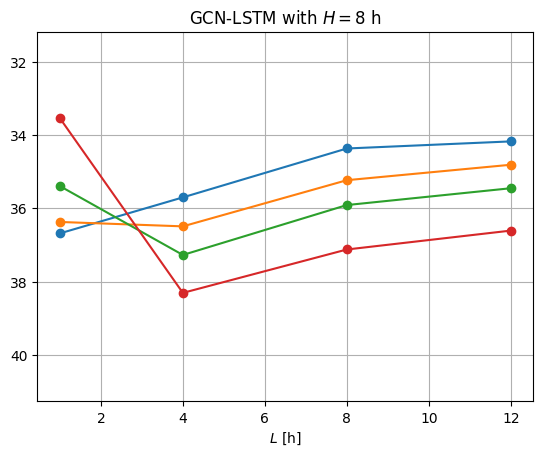

In [42]:
results_df = pd.read_csv(temporal_results_path)
architectures = ["mlp", "lstm", "gcn", "gcn_lstm"]
resolutions = ["10min", "20min", "30min", "60min"]
look_back_hours = [1, 4, 8, 12]
horizons = [1, 4, 8]
results_df["forecasting_hours"] = results_df["forecasting_hours"].astype(int)

plot_legend = True

for horizon in horizons:
    horizon_subset = results_df[results_df["forecasting_hours"] == horizon]
    rmse_vals = horizon_subset[horizon_subset["model_architecture"].isin(architectures)]["RMSE"]
    persistence_vals = results_df[
        (results_df["model_architecture"] == "persistence")
        & (results_df["forecasting_hours"] == horizon)
    ]["RMSE"]

    global_min = rmse_vals.min()
    global_max = rmse_vals.max()

    margin = 0.05 * (global_max - global_min)
    y_min, y_max = global_min - margin, global_max + margin

    persistence_rmse = persistence_vals.values[0] if len(persistence_vals) > 0 else None

    for arch in architectures:
        subset = horizon_subset[horizon_subset["model_architecture"] == arch]

        plt.figure()
        for res in resolutions:
            sub_res = subset[
                (subset["resolution"] == res) & (subset["look_back_hours"].isin(look_back_hours))
            ]
            sub_res = sub_res.sort_values("look_back_hours")

            plt.plot(
                sub_res["look_back_hours"],
                sub_res["RMSE"],
                marker="o",
                label=str(res),
            )

        # # Add persistence baseline
        # plt.hlines(
        #     y=persistence_rmse,
        #     xmin=min(look_back_hours),
        #     xmax=max(look_back_hours),
        #     colors="gray",
        #     linestyles="dashed",
        #     label="Persistence",
        # )

        plt.xlabel("$L$ [h]")
        plt.ylabel(
            r"$\text{RMSE}^{\mathcal{D}_{\text{eval}}}_\text{model} \; \left[ \frac{m}{s} \right]$"
        )
        plt.title(
            f"{'GCN-LSTM' if arch == 'gcn_lstm' else arch.upper()} with " + rf"$H = {horizon}$ h"
        )
        plt.ylim(y_min, y_max)

        if plot_legend:
            plt.legend(title="Legend", bbox_to_anchor=(1.00, 0.95))
            plot_legend = False

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if persistence_rmse is not None and persistence_rmse != 0:
            plt.figure()
            for res in resolutions:
                sub_res = subset[
                    (subset["resolution"] == res)
                    & (subset["look_back_hours"].isin(look_back_hours))
                ]
                sub_res = sub_res.sort_values("look_back_hours")

                improvement_percent = calculate_percentage_improvement(
                    persistence_rmse, sub_res["RMSE"]
                )

                plt.plot(
                    sub_res["look_back_hours"],
                    improvement_percent,
                    marker="o",
                    label=str(res),
                )

            plt.xlabel("$L$ [h]")
            # plt.ylabel(r"$\text{rRMSE}_{\text{model},\text{persistence}$ [\%]")
            plt.title(
                f"{'GCN-LSTM' if arch == 'gcn_lstm' else arch.upper()} with "
                + rf"$H = {horizon}$ h"
            )
            plt.ylim(
                calculate_percentage_improvement(persistence_rmse, y_min),
                calculate_percentage_improvement(persistence_rmse, y_max),
            )
            plt.grid(True)
            # plt.tight_layout()
            plt.show()